## Importing the necessary libraries

In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud
!pip install swifter
 
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import swifter
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 495.5 kB/s eta 0:00:26
      --------------------------------------- 0.2/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.6/12.8 MB 3.8 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.8 MB 4.4 MB/s eta 0:00:03
     --- ------------------------------------ 1.1/12.8 MB 4.3 MB/s eta 0:00:03
     --- ------------------------------------ 1.1/12.8 MB 4.4 MB/s eta 0:00:03
     --- ------------------------------------ 1.1/12.8 MB 4.4 MB/s eta 0:00:03
     ---- ----------------------------------- 1.4/12.8 MB 3.5 MB/s eta 0:00:04
     ---- ----------------------------------- 1.6/12.8 MB 3.6 MB/s eta 0:00:04
     ----- ---------------------------------- 1.8/12.8 MB 3.7 MB/s eta 0:00:03
     ------ --------------------------------- 1.9/12.8 MB 3.7 MB/

## Loading the data

In [2]:
# importing the 'json' module to open json file
import json

with open('complaints-2021-05-14_08_16.json','r') as f:
    data = json.load(f)
    

## Data preparation

In [3]:
# Convert JSON data to a DataFrame
df = pd.DataFrame(data)
df=pd.json_normalize(data)

In [4]:

# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [5]:
#concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
df.shape

(78313, 22)

In [8]:
#Assign new column names
df.rename(columns={'_source.tags':'tags',
                   '_source.zip_code':'zip_code',
                   '_source.complaint_id':'complaint_id',
                   '_source.issue':'issue',
                   '_source.date_received':'date_received',
                   '_source.state':'state',
                   '_source.consumer_disputed':'consumer_disputed',
                   '_source.product':'product',
                   '_source.company_response':'company_response',
                   '_source.company':'company',
                   '_source.submitted_via':'submitted_via',
                   '_source.date_sent_to_company':'date_sent_to_company',
                   '_source.company_public_response':'company_public_response',
                   '_source.sub_product':'sub_product',
                   '_source.timely':'timely',
                   '_source.complaint_what_happened':'complaint_what_happened',
                   '_source.sub_issue':'sub_issue',
                   '_source.consumer_consent_provided':'consumer_consent_provided'},
          inplace=True)

In [9]:
# Calculate missing values in each column of the DataFrame
missing_values = df.isna().sum()

print("Missing values in each column:")

# Display the count of missing values for each column
print(missing_values)

Missing values in each column:
_index                           0
_type                            0
_id                              0
_score                           0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64


In [10]:
# the percentage of missing values in each column of the DataFrame
missing_values_percentage = (df.isna().sum() / len(df)) * 100

print("Missing values percentage in each column:")

# Display the percentage of missing values for each column
print(missing_values_percentage)


Missing values percentage in each column:
_index                        0.000000
_type                         0.000000
_id                           0.000000
_score                        0.000000
tags                         86.081493
zip_code                      8.628197
complaint_id                  0.000000
issue                         0.000000
date_received                 0.000000
state                         2.542362
consumer_disputed             0.000000
product                       0.000000
company_response              0.000000
company                       0.000000
submitted_via                 0.000000
date_sent_to_company          0.000000
company_public_response      99.994892
sub_product                  13.498397
timely                        0.000000
complaint_what_happened       0.000000
sub_issue                    59.117899
consumer_consent_provided     1.287143
dtype: float64


In [11]:
# Display the shape of the DataFrame before dropping the column
print("Shape of DataFrame before dropping the column:", df.shape)

Shape of DataFrame before dropping the column: (78313, 22)


In [12]:
# Droping 'tags' column
# With 86.08% missing values, it might be challenging to derive meaningful insights from this column.
df.drop(columns=['tags'], inplace=True)

# Droping 'company_public_response' column
# With 99.99% missing values, this column may not contribute much to your analysis.
df.drop(columns=['company_public_response'], inplace=True)

# Verify the changes
print("\nDataFrame after dropping specified columns:")
print(df.head())


DataFrame after dropping specified columns:
                _index      _type      _id  _score zip_code complaint_id  \
0  complaint-public-v2  complaint  3211475     0.0    90301      3211475   
1  complaint-public-v2  complaint  3229299     0.0    319XX      3229299   
2  complaint-public-v2  complaint  3199379     0.0    77069      3199379   
3  complaint-public-v2  complaint  2673060     0.0    48066      2673060   
4  complaint-public-v2  complaint  3203545     0.0    10473      3203545   

                                issue              date_received state  \
0   Attempts to collect debt not owed  2019-04-13T12:00:00-05:00    CA   
1     Written notification about debt  2019-05-01T12:00:00-05:00    GA   
2  Other features, terms, or problems  2019-04-02T12:00:00-05:00    TX   
3      Trouble during payment process  2017-09-13T12:00:00-05:00    MI   
4                    Fees or interest  2019-04-05T12:00:00-05:00    NY   

  consumer_disputed                      product     

In [13]:
#the DataFrame after dropping the column
print("Shape of DataFrame after dropping the column:", df.shape)

Shape of DataFrame after dropping the column: (78313, 20)


## Prepare the text for topic modeling

In [14]:
# Function to clean the text and remove all the unnecessary elements.
def clean_data(text):
    # Check if the text is empty or contains only spaces
    if not text or text.isspace():
        return ''

In [15]:
# Function to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [16]:
# Apply data cleaning to the complaints_what_happened column
df['complaints'] = df['complaint_what_happened'].apply(clean_data)
df.head()


,_index,_type,_id,_score,zip_code,complaint_id,issue,date_received,state,consumer_disputed,...,company_response,company,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints
0,complaint-public-v2,complaint,3211475,0.0,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Debt is not yours,Consent not provided,
1,complaint-public-v2,complaint,3229299,0.0,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is and i appreciate it if...
2,complaint-public-v2,complaint,3199379,0.0,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my card in and was told by the agen...
3,complaint-public-v2,complaint,2673060,0.0,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,None,Consent not provided,
4,complaint-public-v2,complaint,3203545,0.0,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A,


In [17]:
# Function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [18]:
# Create a dataframe ('df_clean') with original complaints and lemmatized complaints
df_clean = pd.DataFrame({
    'complaints': df['complaints'],
    'lemmatized': df['complaints'].apply(lemmatization)
})

In [19]:
# Display the cleaned DataFrame
df_clean.head()

,complaints,lemmatized
0,,
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
3,,
4,,


In [20]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)


Pandas Apply:   0%|          | 0/78313 [00:00<?, ?it/s]

In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
0,,,
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...
3,,,
4,,,
...,...,...,...
78308,,,
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit chase credit card chase freedom problem...


# Exploratory data analysis to get familiar with the data.
### Data visulaisation:

* Visualise the data according to the 'Complaint' character length
* Using a word cloud find the top 40 words by frequency among all the articles after processing the text
* Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. 

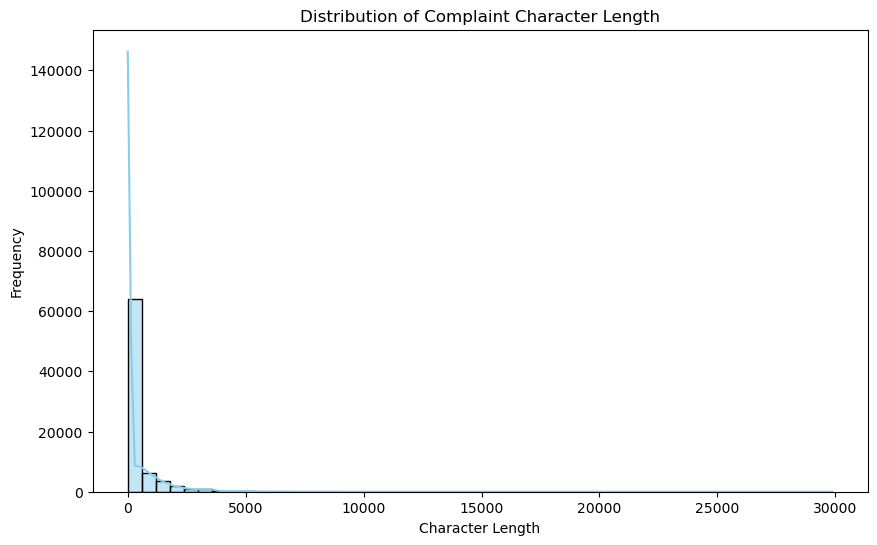

In [22]:
# Visualize the data according to 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaints'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['complaint_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()


## Find the top 40 words by frequency among all the articles after processing the text.

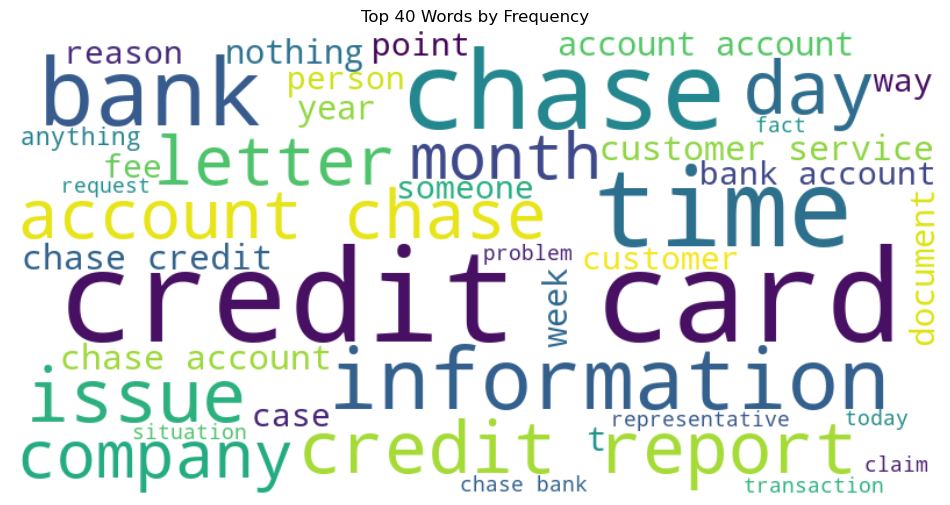

In [23]:
# Using a word cloud, find the top 40 words by frequency among all the articles after processing the text
all_text = ' '.join(df_clean['complaint_POS_removed'].dropna())
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(all_text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency')
plt.show()

In [24]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaints,lemmatized,complaint_POS_removed,complaint_length,Complaint_clean
0,,,,0,
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,440,morning name stop bank service debt verificati...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,297,card agent anniversary date agent information ...
3,,,,0,
4,,,,0,
...,...,...,...,...,...
78308,,,,0,
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,2006,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,2252,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit chase credit card chase freedom problem...,1920,credit chase credit card chase freedom problem...


## Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

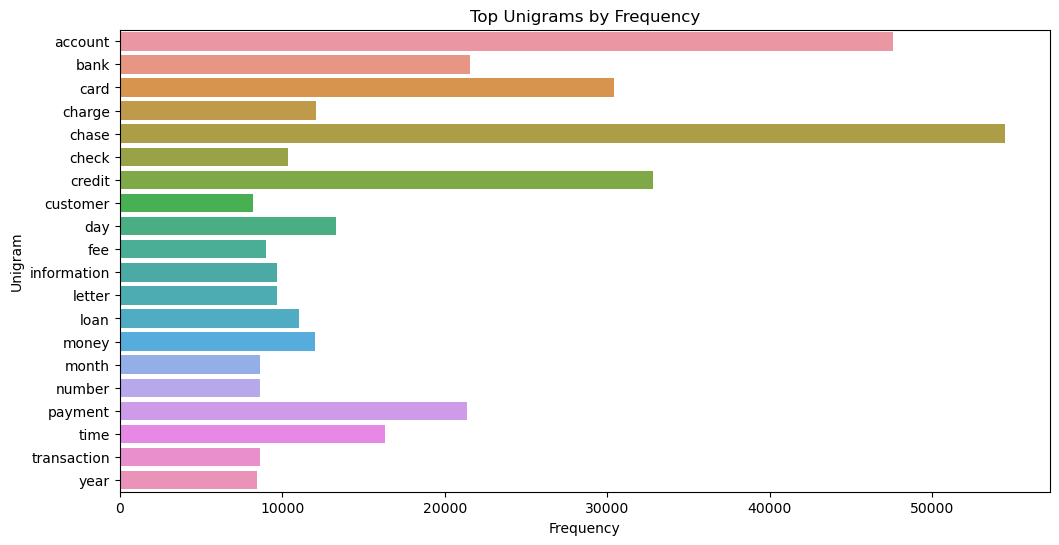

In [25]:
# Find the top unigrams, bigrams, and trigrams by frequency among all the complaints after processing the text
vectorizer = CountVectorizer(stop_words='english', max_features=20)
complaints_vectorized = vectorizer.fit_transform(df_clean['complaint_POS_removed'].dropna())

# Get feature names (unigrams)
unigrams = vectorizer.get_feature_names_out()

# Plot the top unigrams
plt.figure(figsize=(12, 6))
sns.barplot(x=complaints_vectorized.sum(axis=0).A1, y=unigrams)
plt.title('Top Unigrams by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Unigram')
plt.show()

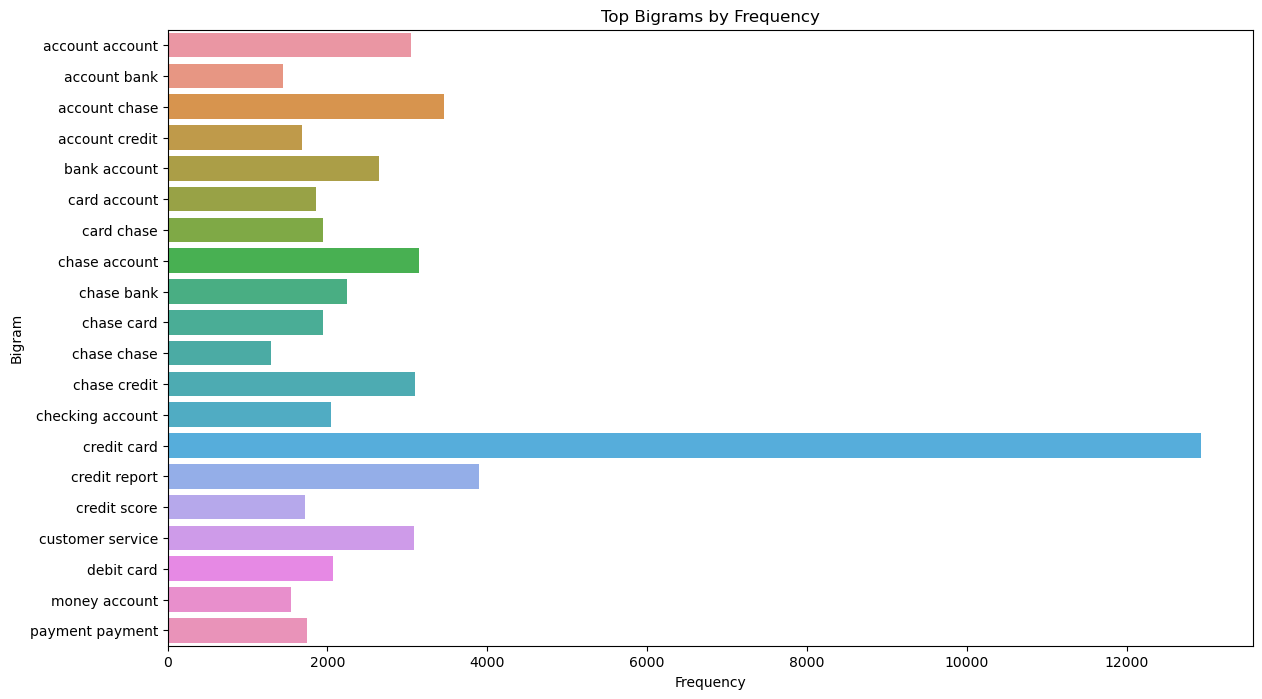

In [26]:
# Find the top bigrams by frequency among all the complaints after processing the text
vectorizer_bigrams = CountVectorizer(stop_words='english', ngram_range=(2, 2), max_features=20)
complaints_vectorized_bigrams = vectorizer_bigrams.fit_transform(df_clean['complaint_POS_removed'].dropna())
bigrams = vectorizer_bigrams.get_feature_names_out()

# Plot the top bigrams
plt.figure(figsize=(14, 8))
sns.barplot(x=complaints_vectorized_bigrams.sum(axis=0).A1, y=bigrams)
plt.title('Top Bigrams by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

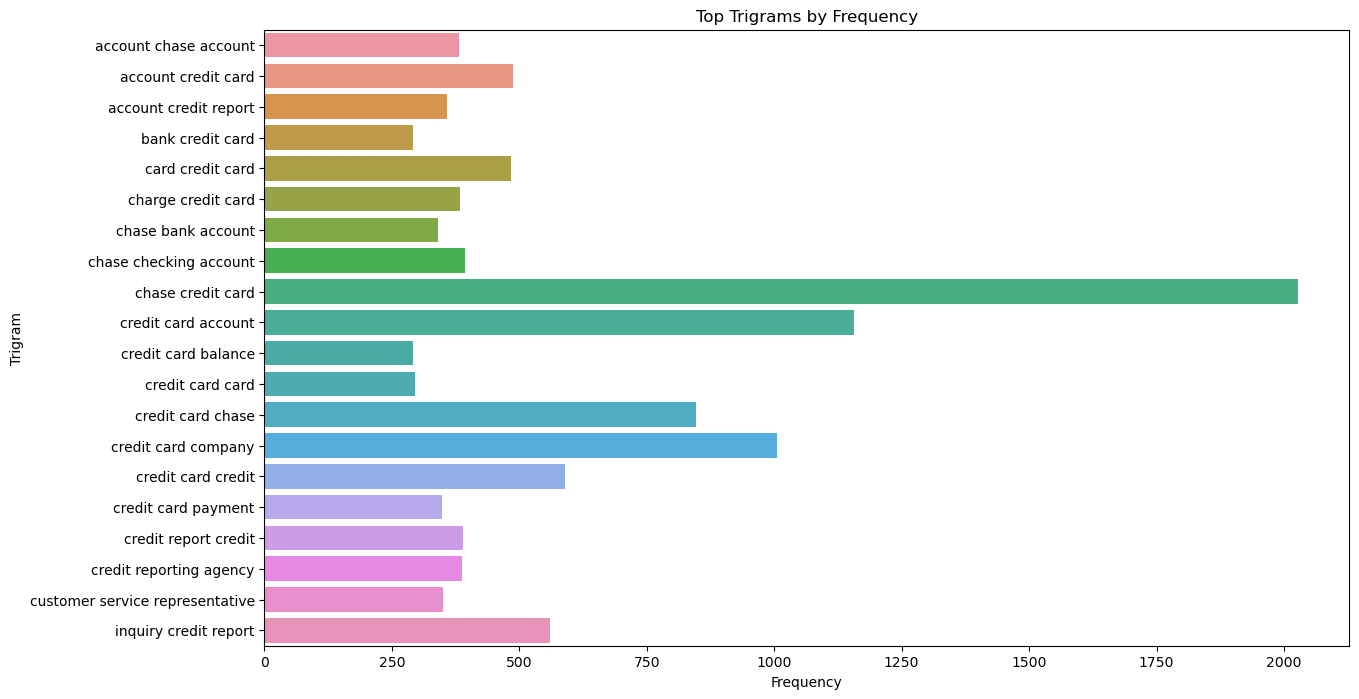

In [27]:
# Find the top trigrams by frequency among all the complaints after processing the text
vectorizer_trigrams = CountVectorizer(stop_words='english', ngram_range=(3, 3), max_features=20)
complaints_vectorized_trigrams = vectorizer_trigrams.fit_transform(df_clean['complaint_POS_removed'].dropna())
trigrams = vectorizer_trigrams.get_feature_names_out()

# Plot the top trigrams
plt.figure(figsize=(14, 8))
sns.barplot(x=complaints_vectorized_trigrams.sum(axis=0).A1, y=trigrams)
plt.title('Top Trigrams by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def get_top_ngrams(texts, ngram_range=(1, 1), max_features=10):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range, max_features=max_features)
    vectorized_texts = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Create a DataFrame with feature names and their corresponding frequencies
    ngrams_df = pd.DataFrame({
        'Ngram': feature_names,
        'Frequency': vectorized_texts.sum(axis=0).A1
    })

    # Sort the DataFrame by frequency in descending order
    ngrams_df = ngrams_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

    return ngrams_df

# Example for unigrams (N=1)
df_unigram = get_top_ngrams(df_clean['complaint_POS_removed'], ngram_range=(1, 1), max_features=10)
print("Top 10 Unigrams:")
print(df_unigram)

# Example for bigrams (N=2)
df_bigram = get_top_ngrams(df_clean['complaint_POS_removed'], ngram_range=(2, 2), max_features=10)
print("\nTop 10 Bigrams:")
print(df_bigram)

# Example for trigrams (N=3)
df_trigram = get_top_ngrams(df_clean['complaint_POS_removed'], ngram_range=(3, 3), max_features=10)
print("\nTop 10 Trigrams:")
print(df_trigram)


Top 10 Unigrams:
     Ngram  Frequency
0    chase      54491
1  account      47556
2   credit      32787
3     card      30436
4     bank      21568
5  payment      21367
6     time      16311
7      day      13322
8   charge      12082
9    money      12001

Top 10 Bigrams:
              Ngram  Frequency
0       credit card      12931
1     credit report       3892
2     account chase       3452
3     chase account       3149
4      chase credit       3097
5  customer service       3082
6   account account       3041
7      bank account       2639
8        chase bank       2244
9        debit card       2067

Top 10 Trigrams:
                    Ngram  Frequency
0       chase credit card       2027
1     credit card account       1156
2     credit card company       1005
3       credit card chase        846
4      credit card credit        589
5   inquiry credit report        560
6     account credit card        488
7        card credit card        483
8  chase checking account       

In [29]:
df_clean

,complaints,lemmatized,complaint_POS_removed,complaint_length,Complaint_clean
0,,,,0,
1,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank service debt verificati...,440,morning name stop bank service debt verificati...
2,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,297,card agent anniversary date agent information ...
3,,,,0,
4,,,,0,
...,...,...,...,...,...
78308,,,,0,
78309,on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,2006,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer chase bank app chase year ba...,2252,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yr i ve had cha...,credit chase credit card chase freedom problem...,1920,credit chase credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

min_df is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"


In [30]:
# Feature Extraction: Convert raw texts to a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])

## Create a document term matrix using fit_transform
The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score: The tuples that are not there have a tf-idf score of 0

In [31]:
# Document Term Matrix using fit_transform
document_term_matrix = pd.DataFrame(tfidf_matrix.toarray(), index=df_clean.index, columns=tfidf_vectorizer.get_feature_names_out())


# Topic Modelling using NMF
Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. 
The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation.
These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we will perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


In [33]:
# Topic Modelling using NMF
def find_best_num_clusters(matrix, max_clusters=10):
    reconstruction_errors = []
    for i in range(1, max_clusters + 1):
        nmf = NMF(n_components=i, random_state=42)
        nmf.fit(matrix)
        reconstruction_errors.append(nmf.reconstruction_err_)

    # Plotting the elbow curve to find the best number of clusters
    plt.plot(range(1, max_clusters + 1), reconstruction_errors, marker='o')
    plt.title('Elbow Curve for Number of Clusters (Topics)')
    plt.xlabel('Number of Clusters (Topics)')
    plt.ylabel('Reconstruction Error')
    plt.show()


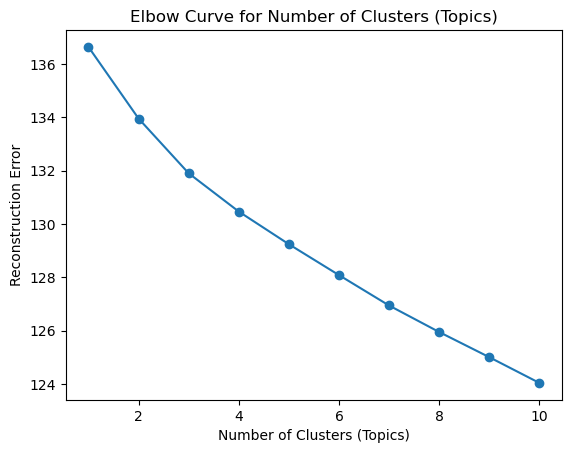

In [34]:
# Find the best number of clusters
find_best_num_clusters(tfidf_matrix, max_clusters=10)


In [35]:
# Apply the best number of clusters (let's say 5 for example)
num_clusters = 5
nmf_model = NMF(n_components=num_clusters, random_state=42)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

In [36]:
# Create word clusters and inspect & validate each cluster
feature_names = tfidf_vectorizer.get_feature_names_out()
for i, topic in enumerate(nmf_model.components_):
    top_features_idx = topic.argsort()[-10:][::-1]
    top_features = [feature_names[idx] for idx in top_features_idx]
    print(f"Cluster {i + 1} Top Features: {top_features}")


Cluster 1 Top Features: ['account', 'chase', 'balance', 'checking', 'fee', 'branch', 'fund', 'reason', 'money', 'number']
Cluster 2 Top Features: ['credit', 'card', 'report', 'inquiry', 'score', 'company', 'balance', 'limit', 'debt', 'bureau']
Cluster 3 Top Features: ['payment', 'loan', 'mortgage', 'chase', 'month', 'time', 'home', 'year', 'modification', 'balance']
Cluster 4 Top Features: ['chase', 'charge', 'card', 'transaction', 'dispute', 'fraud', 'claim', 'time', 'service', 'letter']
Cluster 5 Top Features: ['check', 'bank', 'money', 'fund', 'day', 'deposit', 'transaction', 'branch', 'claim', 'time']


## Manual Topic Modeling
We need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good our final topics are.

In [37]:
# Load your complaints (replace 'complaints_column' with the actual column name in your DataFrame)
complaints = df_clean['complaint_POS_removed']

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = tfidf_vectorizer.fit_transform(complaints)

In [38]:
# Load your nmf_model with the n_components i.e. 5
num_topics = 5
nmf_model = NMF(random_state=40, n_components=num_topics)
nmf_model.fit(dtm)

NMF(n_components=5, random_state=40)

In [39]:
# Print the Top 15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                               columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]
    
print(topic_words_df)

          Word 1  Word 2    Word 3       Word 4   Word 5   Word 6  \
Topic 1  account   chase   balance     checking      fee   branch   
Topic 2   credit    card    report      inquiry    score  company   
Topic 3  payment    loan  mortgage        chase    month     time   
Topic 4    chase  charge      card  transaction  dispute    fraud   
Topic 5    check    bank     money         fund      day  deposit   

              Word 7  Word 8        Word 9  Word 10      Word 11   Word 12  \
Topic 1         fund  reason         money   number  information   deposit   
Topic 2      balance   limit          debt   bureau  application      year   
Topic 3         home    year  modification  balance          fee      rate   
Topic 4        claim    time       service   letter     merchant  purchase   
Topic 5  transaction  branch         claim     time     business  customer   

          Word 13      Word 14    Word 15  
Topic 1  business         bank        day  
Topic 2      bank  informati

In [40]:
# Create the best topic for each complaint in terms of integer value 0, 1, 2, 3 & 4
topic_results = nmf_model.transform(dtm)
topic_assignments = topic_results.argmax(axis=1)

# Assign the best topic to each of the complaints in 'Topic' Column
df_clean['Topic'] = topic_assignments

In [41]:
# Print the first 5 Complaints for each of the Topics
First5_comp = df_clean.groupby('Topic').head(5)
print(First5_comp.sort_values('Topic'))


                                           complaints  \
0                                                       
2   i upgraded my card in and was told by the agen...   
3                                                       
4                                                       
5                                                       
10  chase card was reported on however fraudulent ...   
11  on while trying to book a ticket i came across...   
15                      can you please remove inquiry   
26  i have reached out to several times in attempt...   
23  i have a chase credit card which is incorrectl...   
58  i made a purchase of on i made payments of on ...   
57  i have been trying to do a loan modification w...   
82  i recently called to ask chase bank why they r...   
20  during the summer months i eperience a decline...   
81  i bought a new on from in i paid the loan in b...   
32  my chase amazon card was declined for a cateri...   
43  chase sent me an email toda

## After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Payment Issues
* Customer Service    
* Account and Banking   
* Credit Card Issues     
* Fraud and Security    

In [42]:
# Dictionary mapping numeric topics to their corresponding names
topic_names_mapping = {0: 'Payment Issues', 1: 'Credit Card Issues', 2: 'Account and Banking', 3: 'Customer Service', 4: 'Fraud and Security'}

# Create a new column 'Topic_Labels' based on the numeric topics
df_clean['Topic_Labels'] = df_clean['Topic'].map(topic_names_mapping)

# Print the counts of each topic label
print(df_clean['Topic_Labels'].value_counts())


Topic_Labels
Payment Issues         60493
Customer Service        5798
Account and Banking     4533
Credit Card Issues      4373
Fraud and Security      3116
Name: count, dtype: int64


## Label Encoding and Training Data Preparation

In [43]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'Topic_Labels' column to numerical labels
df_clean['Topic_Labels_encoded'] = label_encoder.fit_transform(df_clean['Topic_Labels'])

# Print the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Display the new DataFrame with encoded labels
print(df_clean[['Topic_Labels', 'Topic_Labels_encoded']].head())



Label Mapping: {'Account and Banking': 0, 'Credit Card Issues': 1, 'Customer Service': 2, 'Fraud and Security': 3, 'Payment Issues': 4}
         Topic_Labels  Topic_Labels_encoded
0      Payment Issues                     4
1  Fraud and Security                     3
2      Payment Issues                     4
3      Payment Issues                     4
4      Payment Issues                     4


## Preparing Training Data for Supervised Models

In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

# Keep the relevant columns in the new dataframe --> training_data
training_data = df_clean[['complaints', 'Topic_Labels_encoded']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training_data['complaints'], training_data['Topic_Labels_encoded'], test_size=0.2, random_state=42)

# Create the vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

# Transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Now X_train_tfidf contains the TF-IDF features, and y_train contains the corresponding labels (topics)

## 1. Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create a Logistic Regression Classifier
logreg_classifier = LogisticRegression(random_state=42)

# Fit the classifier on the training data
logreg_classifier.fit(X_train_tfidf, y_train)

# Transform the test data using the same vectorizer and transformer
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Predict the labels for the test set
y_pred = logreg_classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 96.56%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       965
           1       0.93      0.88      0.90       893
           2       0.88      0.88      0.88      1183
           3       0.90      0.80      0.85       661
           4       0.98      0.99      0.99     11961

    accuracy                           0.97     15663
   macro avg       0.92      0.89      0.91     15663
weighted avg       0.96      0.97      0.97     15663



## 2. Decision Tree Classifier

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
dt_classifier.fit(X_train_tfidf, y_train)

# Transform the test data using the same vectorizer and transformer
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Predict the labels for the test set
y_pred = dt_classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 93.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       965
           1       0.78      0.81      0.80       893
           2       0.72      0.70      0.71      1183
           3       0.71      0.66      0.68       661
           4       0.98      0.99      0.99     11961

    accuracy                           0.93     15663
   macro avg       0.80      0.79      0.80     15663
weighted avg       0.93      0.93      0.93     15663



## 3. Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier on the training data
rf_classifier.fit(X_train_tfidf, y_train)

# Transform the test data using the same vectorizer and transformer
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Predict the labels for the test set
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 92.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       965
           1       0.77      0.74      0.75       893
           2       0.64      0.83      0.72      1183
           3       0.84      0.53      0.65       661
           4       0.99      0.98      0.98     11961

    accuracy                           0.93     15663
   macro avg       0.81      0.79      0.79     15663
weighted avg       0.93      0.93      0.93     15663



## 4. Gaussian Naive Bayes (Optional)

In [48]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Create a Gaussian Naive Bayes Classifier
nb_classifier = GaussianNB()

# Convert TF-IDF features to dense format (required for Gaussian Naive Bayes)
X_train_tfidf_dense = X_train_tfidf.toarray()

# Fit the classifier on the training data
nb_classifier.fit(X_train_tfidf_dense, y_train)

# Transform the test data using the same vectorizer and transformer
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf_dense = X_test_tfidf.toarray()

# Predict the labels for the test set
y_pred = nb_classifier.predict(X_test_tfidf_dense)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 82.54%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.35      0.39       965
           1       0.33      0.58      0.42       893
           2       0.43      0.33      0.37      1183
           3       0.28      0.35      0.31       661
           4       0.99      0.96      0.97     11961

    accuracy                           0.83     15663
   macro avg       0.49      0.51      0.49     15663
weighted avg       0.84      0.83      0.83     15663



## Clearly Logistic Regression is performing better

### Infering the best model

In [51]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints


,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [52]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [53]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Account Services
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Theft/Dispute Reporting
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Theft/Dispute Reporting
5,I need to know the number of bank branches and...,Credit card or prepaid card


## Conclusion

# As expected 5 topics were indetified namely:
* 1. Payment Issues
* 2. Customer Service
* 3. Account and Banking
* 4. Credit Card Issues
* 5. Fraud and Security

## Tried 4 models on the data with accuracies as follows:

| Model | Accuracy | | ----------- | ----------- | |
Logistic Regression | 0.97% | | Decision Tree | 0.93% | | Random Forest | 0.93% | | Naive Bayes | 0.83% |

